# Práctica entregable: Preparación de datos

Base de datos con características sanitarias para tratar de predecir cáncer cervical. El dataset está accesible desde https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29.
Se trata de un problema de clasificación. La variable objetivo binaria es "Biopsy", que indica (0 - False, 1 - True) si ha sufrido cáncer cervical.

## 0. Importación de paquetes

Importamos los paquetes que utilizaremos en el desarrollo de la práctica.

In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, clone

In [4]:
from sklearn.feature_selection import VarianceThreshold

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn import linear_model
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer 

In [6]:
from sklearn.neighbors import LocalOutlierFactor

In [7]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [9]:
from sklearn.metrics import accuracy_score

## 1. Lectura y análisis del dataset

### 1.1. Importación de datos

Realizamos la importación de los datos. Estudiando el archivo csv vemos que los valores nulos vienen representados mediante el caracter '?', así que lo indicamos en el momento de la importación para que se identifiquen automáticamente.

In [10]:
df = pd.read_csv('risk_factors_cervical_cancer.csv', delimiter=',', na_values='?') #leer dataset

### 1.2. Estudio inicial del dataset

Vemos que el dataset se compone de un total de 858 registros con 36 variables. En los pasos posteriores seleccionaremos algunas de estas columnas y eliminaremos algunas de las filas.

In [11]:
print(df.shape) 

(858, 36)


Comenzamos estudiando los primeros registros del dataset, lo que nos da una idea inicial de cómo son sus datos. Podemos intuir a priori que el dataset no está balanceado (las cuatro columnas target tienen *0* o *False* como valor en los 5 registros) y que las columnas STDs tienen gran cantidad de nulos.

In [12]:
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0


Extraigamos algo más de información sobre cada columna. Como vemos, todas son numéricas, lo que nos facilitará el estudio al no tener que trabajar con variables categóricas. No obstante, tenemos que tener en cuenta que muchas de ellas son booleanas, algunas codificadas como enteras y otras como reales.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           832 non-null    float64
 2   First sexual intercourse            851 non-null    float64
 3   Num of pregnancies                  802 non-null    float64
 4   Smokes                              845 non-null    float64
 5   Smokes (years)                      845 non-null    float64
 6   Smokes (packs/year)                 845 non-null    float64
 7   Hormonal Contraceptives             750 non-null    float64
 8   Hormonal Contraceptives (years)     750 non-null    float64
 9   IUD                                 741 non-null    float64
 10  IUD (years)                         741 non-null    float64
 11  STDs                                753 non-n

Pasemos a estudiar en más profundidad las variables. Estudiando los percentiles junto a la media podemos hacernos una idea del rango, la normalidad y la asimetría de las variables numéricas. Con la desviación típica podemos ver las variaciones entre los valores de cada columna, especialmente en las booleanas.

In [14]:
df.describe()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
count,858.000000,832.000000,851.000000,802.000000,845.000000,845.000000,845.000000,750.000000,750.000000,741.000000,...,71.000000,71.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,26.820513,2.527644,16.995300,2.275561,0.145562,1.219721,0.453144,0.641333,2.256419,0.112011,...,6.140845,5.816901,0.020979,0.010490,0.020979,0.027972,0.040793,0.086247,0.051282,0.064103
std,8.497948,1.667760,2.803355,1.447414,0.352876,4.089017,2.226610,0.479929,3.764254,0.315593,...,5.895024,5.755271,0.143398,0.101939,0.143398,0.164989,0.197925,0.280892,0.220701,0.245078
min,13.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,2.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,2.000000,17.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.000000,...,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,3.000000,18.000000,3.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,...,8.000000,7.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,84.000000,28.000000,32.000000,11.000000,1.000000,37.000000,37.000000,1.000000,30.000000,1.000000,...,22.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Aunque las últimas 4 variables son targets según la descripción del dataset, para nuestro trabajo trataremos de predecir la última: "Biopsy", que indica el resultado de la biopsia para el cáncer cervical. En función de la infomración que dispongamos para realizar las predicciones futuras, habría que realizar el estudio con o sin las otras 3 variables. Para nuestro caso, asumiremos que no disponemos de esta información.

In [15]:
df.iloc[:,[-4,-3,-2,-1]].head(10)

,Hinselmann,Schiller,Citology,Biopsy
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
5,0,0,0,0
6,1,1,0,1
7,0,0,0,0
8,0,0,0,0
9,0,0,0,0


Como es evidente, ambas variables están positivamente correlacionadas por parejas.

In [16]:
df.iloc[:,[-4,-3,-2,-1]].corr()

,Hinselmann,Schiller,Citology,Biopsy
Hinselmann,1.000000,0.650249,0.192467,0.547417
Schiller,0.650249,1.000000,0.361486,0.733204
Citology,0.192467,0.361486,1.000000,0.327466
Biopsy,0.547417,0.733204,0.327466,1.000000


In [17]:
df.drop(["Hinselmann", "Schiller", "Citology"], axis=1, inplace=True)
df.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Biopsy'],
      dtype='object')

## 2. Preprocesado

### 2.1. Limpieza básica de datos

Para limpiar los datos, vamos a eliminar las columnas que contengan un único valor y a estudiar aquellas que tengan un bajo número de valores diferentes o una baja varianza. También vamos a eliminar las filas repetidas. Por último, estudiaremos tanto los valores nulos, realizando el borrado o las imputaciones correspondientes, como los outliers, aplicando las técnicas estudiadas en clase.

#### 2.1.1. Valores únicos

##### 2.1.1.1. Identificación de columnas con valores únicos

Lo primero que se comprueba es si alguna de las columnas númericas tiene un único valor, puesto que en ese caso la columna no aporta información.

In [18]:
import numpy as np
df.nunique()

Age                                   44
Number of sexual partners             12
First sexual intercourse              21
Num of pregnancies                    11
Smokes                                 2
Smokes (years)                        30
Smokes (packs/year)                   62
Hormonal Contraceptives                2
Hormonal Contraceptives (years)       40
IUD                                    2
IUD (years)                           26
STDs                                   2
STDs (number)                          5
STDs:condylomatosis                    2
STDs:cervical condylomatosis           1
STDs:vaginal condylomatosis            2
STDs:vulvo-perineal condylomatosis     2
STDs:syphilis                          2
STDs:pelvic inflammatory disease       2
STDs:genital herpes                    2
STDs:molluscum contagiosum             2
STDs:AIDS                              1
STDs:HIV                               2
STDs:Hepatitis B                       2
STDs:HPV        

Vemos que existen columnas con un único valor. Identifiquémoslas todas.

In [19]:
df.nunique()[df.nunique().array == 1]

STDs:cervical condylomatosis    1
STDs:AIDS                       1
dtype: int64

##### 2.1.1.2. Borrado de columnas con valores únicos

Eliminemos estas dos columnas de forma automática.

In [20]:
print(df.shape)
to_del = df.nunique()[df.nunique().array == 1].index
df.drop(to_del, axis=1, inplace=True)
print(df.shape)

(858, 33)
(858, 31)


Una vez eliminadas estas variables, pasemos a mostrar de nuevo un resumen de las columnas.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           832 non-null    float64
 2   First sexual intercourse            851 non-null    float64
 3   Num of pregnancies                  802 non-null    float64
 4   Smokes                              845 non-null    float64
 5   Smokes (years)                      845 non-null    float64
 6   Smokes (packs/year)                 845 non-null    float64
 7   Hormonal Contraceptives             750 non-null    float64
 8   Hormonal Contraceptives (years)     750 non-null    float64
 9   IUD                                 741 non-null    float64
 10  IUD (years)                         741 non-null    float64
 11  STDs                                753 non-n

#### 2.1.2. Baja variedad de valores

##### 2.1.2.1. Identificación de columnas con baja variedad de valores

Para llevar a cabo la identificación de las variables que tienen una baja variedad de valores, mostremos para cada una el número de valores únicos que toma y el porcentaje que supone respecto al total de registros.

In [22]:
# summarize the number of unique values in each column
for i in range(df.shape[1]):
    num = len(np.unique(df.iloc[:, i]))
    percentage = num / df.shape[0] * 100
    print('%d \t %d \t %.1f%% \t %s' % (i, num, percentage, df.columns[i]))

0 	 44 	 5.1% 	 Age
1 	 13 	 1.5% 	 Number of sexual partners
2 	 22 	 2.6% 	 First sexual intercourse
3 	 12 	 1.4% 	 Num of pregnancies
4 	 3 	 0.3% 	 Smokes
5 	 31 	 3.6% 	 Smokes (years)
6 	 63 	 7.3% 	 Smokes (packs/year)
7 	 3 	 0.3% 	 Hormonal Contraceptives
8 	 41 	 4.8% 	 Hormonal Contraceptives (years)
9 	 3 	 0.3% 	 IUD
10 	 27 	 3.1% 	 IUD (years)
11 	 3 	 0.3% 	 STDs
12 	 6 	 0.7% 	 STDs (number)
13 	 3 	 0.3% 	 STDs:condylomatosis
14 	 3 	 0.3% 	 STDs:vaginal condylomatosis
15 	 3 	 0.3% 	 STDs:vulvo-perineal condylomatosis
16 	 3 	 0.3% 	 STDs:syphilis
17 	 3 	 0.3% 	 STDs:pelvic inflammatory disease
18 	 3 	 0.3% 	 STDs:genital herpes
19 	 3 	 0.3% 	 STDs:molluscum contagiosum
20 	 3 	 0.3% 	 STDs:HIV
21 	 3 	 0.3% 	 STDs:Hepatitis B
22 	 3 	 0.3% 	 STDs:HPV
23 	 4 	 0.5% 	 STDs: Number of diagnosis
24 	 19 	 2.2% 	 STDs: Time since first diagnosis
25 	 19 	 2.2% 	 STDs: Time since last diagnosis
26 	 2 	 0.2% 	 Dx:Cancer
27 	 2 	 0.2% 	 Dx:CIN
28 	 2 	 0.2% 	 Dx:HPV
29

Vemos que hay un alto número de columnas con poca variedad de valores. Esto es debido a dos motivos principales: el alto número de variables booleanas que contiene el dataset y desbalanceo de datos (99.8-0.2% en la columna target).

Mostremos aquellas variables que presenten un porcentaje inferior a 0.8% en la variedad de valores. Vemos que se corresponden mayoritariamente con las variables booleanas.

In [23]:
# summarize the number of unique values in each column
for i in range(df.shape[1]):
    num = len(np.unique(df.iloc[:, i]))
    percentage = float(num) / df.shape[0] * 100
    if percentage < 0.5:
        print('%d \t %d \t %.1f%% \t %s' % (i, num, percentage, df.columns[i]))

4 	 3 	 0.3% 	 Smokes
7 	 3 	 0.3% 	 Hormonal Contraceptives
9 	 3 	 0.3% 	 IUD
11 	 3 	 0.3% 	 STDs
13 	 3 	 0.3% 	 STDs:condylomatosis
14 	 3 	 0.3% 	 STDs:vaginal condylomatosis
15 	 3 	 0.3% 	 STDs:vulvo-perineal condylomatosis
16 	 3 	 0.3% 	 STDs:syphilis
17 	 3 	 0.3% 	 STDs:pelvic inflammatory disease
18 	 3 	 0.3% 	 STDs:genital herpes
19 	 3 	 0.3% 	 STDs:molluscum contagiosum
20 	 3 	 0.3% 	 STDs:HIV
21 	 3 	 0.3% 	 STDs:Hepatitis B
22 	 3 	 0.3% 	 STDs:HPV
23 	 4 	 0.5% 	 STDs: Number of diagnosis
26 	 2 	 0.2% 	 Dx:Cancer
27 	 2 	 0.2% 	 Dx:CIN
28 	 2 	 0.2% 	 Dx:HPV
29 	 2 	 0.2% 	 Dx
30 	 2 	 0.2% 	 Biopsy


In [24]:
perLEQ01 = [df.columns[i] for i in range(df.shape[1]) if float(len(np.unique(df.iloc[:, i]))) / df.shape[0] * 100 < 1] # Columnas con menos de un 1%
perLEQ005 = [df.columns[i] for i in range(df.shape[1]) if float(len(np.unique(df.iloc[:, i]))) / df.shape[0] * 100 < 0.5] # Columnas con menos de un 0.5%
print("Un %.2f de las columnas <1%%, y un %.2f de las columnas <0.5%%." % (len(perLEQ01) / df.shape[1] * 100, len(perLEQ005) / df.shape[1] * 100))

Un 67.74 de las columnas <1%, y un 64.52 de las columnas <0.5%.


Probemos a analizar, para cada porcentaje máximo de entre 0% y 1% a intervalos del 0.05%, cuántas variables nos quedarían en el dataset si eliminásemos todas aquellas con un porcentaje menor.

In [25]:
# get number of unique values for each column
counts = df.iloc[:,:-1].nunique()    #counts = df.iloc[:,:-1]

In [26]:
# define rates to check
rates = np.arange(0., 1., 0.05)
# apply filter with each percentage
for per in rates:
    to_del = [df.columns[i] for i,v in enumerate(counts) if v/df.shape[0]*100 < per]
    print('> Rate=%.2f, Features=%d' % (per, df.shape[1]-len(to_del)))

> Rate=0.00, Features=31
> Rate=0.05, Features=31
> Rate=0.10, Features=31
> Rate=0.15, Features=31
> Rate=0.20, Features=31
> Rate=0.25, Features=13
> Rate=0.30, Features=13
> Rate=0.35, Features=13
> Rate=0.40, Features=13
> Rate=0.45, Features=13
> Rate=0.50, Features=12
> Rate=0.55, Features=12
> Rate=0.60, Features=11
> Rate=0.65, Features=11
> Rate=0.70, Features=11
> Rate=0.75, Features=11
> Rate=0.80, Features=11
> Rate=0.85, Features=11
> Rate=0.90, Features=11
> Rate=0.95, Features=11


##### 2.1.2.2. Borrado de columnas con baja variedad de valores

El hecho de que las variables con baja variedad de datos sean las booleanas nos hace ver que podría ser un error eliminarlas. Para comprobarlo, vamos a quedarnos con las 13 columnas restantes a partir del 0.25% en un dataset aparte, con el objetivo de estudiarlo más a fondo después.

In [27]:
# record columns to delete
to_del = [df.columns[i] for i,v in enumerate(counts) if v/df.shape[0]*100 < 0.25]
print(to_del)

['Smokes', 'Hormonal Contraceptives', 'IUD', 'STDs', 'STDs:condylomatosis', 'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx']


In [28]:
# drop useless columns
df_noFewValuesColumns = df.copy()
print(df_noFewValuesColumns.shape)
df_noFewValuesColumns.drop(to_del, axis=1, inplace=True)
print(df_noFewValuesColumns.shape)

(858, 31)
(858, 13)


#### 2.1.2. Valores de baja varianza

Pasemos a estudiar las variables con baja varianza. Para ello, extraemos primero la variable objetivo.

In [29]:
# split data into inputs and outputs
data = df.values
X = data[:, :-1]
y = data[:, -1]
print(X.shape, y.shape)

(858, 30) (858,)


Aplicamos un transformador Variance Treshold a la *X* para extraer las columnas con una varianza máxima concreta. Con *treshold=0.0* obtendríamos el mismo resultado que el que obtuvimos al eliminar las columnas de valores únicos.

In [30]:
# define the transform
transform = VarianceThreshold()
# transform the input data
X_sel = transform.fit_transform(X)  #remove all columns with a variance of 0.0.
print(X_sel.shape)

(858, 30)


Vayamos eliminando progresivamente variables a medida que aumentamos el treshold de varianza y analicemos el comportamiento.

In [31]:
# define thresholds to check
thresholds = np.arange(0.0, 0.55, 0.05)
# apply transform with each threshold
results = list()
for t in thresholds:
    # define the transform
    transform = VarianceThreshold(threshold=t)
    # transform the input data
    X_sel = transform.fit_transform(X)
    # determine the number of input features
    n_features = X_sel.shape[1]
    print('>Threshold=%.2f, Features=%d' % (t, n_features))
    # store the result
    results.append(n_features)

>Threshold=0.00, Features=30
>Threshold=0.05, Features=18
>Threshold=0.10, Features=13
>Threshold=0.15, Features=12
>Threshold=0.20, Features=12
>Threshold=0.25, Features=11
>Threshold=0.30, Features=11
>Threshold=0.35, Features=10
>Threshold=0.40, Features=10
>Threshold=0.45, Features=10
>Threshold=0.50, Features=10


Representando los valores en una gráfica veremos que un punto que parece ser bueno para "cortar" la eliminación de variables es el 0.15, con lo que obtenemos 13 restantes (contando con la target).

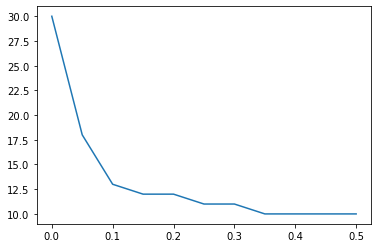

In [32]:
# plot the threshold vs the number of selected features
pyplot.plot(thresholds, results)
pyplot.show()

In [33]:
# define the transform
transform = VarianceThreshold(threshold=0.15)
# transform the input data
X_noLowVarianceColumns = transform.fit_transform(X)
X_noLowVarianceColumns.shape

(858, 12)

Si analizamos el dataset que habíamos generado eliminando columnas con baja variedad de valores, observamos algo interesante.

> Threshold=0.00, Features=12
> Threshold=0.05, Features=12
> Threshold=0.10, Features=11
> Threshold=0.15, Features=11
> Threshold=0.20, Features=11
> Threshold=0.25, Features=11
> Threshold=0.30, Features=11
> Threshold=0.35, Features=10
> Threshold=0.40, Features=10
> Threshold=0.45, Features=10
> Threshold=0.50, Features=10



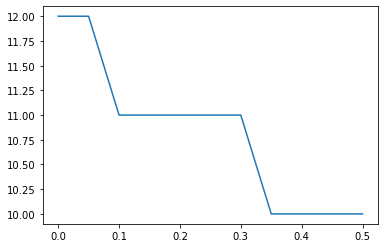

In [34]:
# split data into inputs and outputs
data_noFewValuesColumns = df_noFewValuesColumns.values
X_noFewValuesColumns = data_noFewValuesColumns[:, :-1]

# define thresholds to check
thresholds = np.arange(0.0, 0.55, 0.05)
# apply transform with each threshold
results = list()
for t in thresholds:
    # define the transform
    transform = VarianceThreshold(threshold=t)
    # transform the input data
    X_noFewValuesColumns_sel = transform.fit_transform(X_noFewValuesColumns)
    # determine the number of input features
    n_features = X_noFewValuesColumns_sel.shape[1]
    print('> Threshold=%.2f, Features=%d' % (t, n_features))
    # store the result
    results.append(n_features)
print()

# plot the threshold vs the number of selected features
pyplot.plot(thresholds, results)
pyplot.show()

Podemos observar que las 13 columnas que restaban al hacer el filtrado por baja variedad de valores coinciden precisamente con aquellas con más baja varianza, así que, de ahora en adelante tendremos en cuenta tanto el dataset "base" como el dataset al que se le ha aplicado una reducción de columnas por baja variedad de valores (de menos de un 0.3%), que coincide con el dataset al que se le aplica una reducción de columnas por baja varianza en los valores si tenemos en cuenta un treshold de 0.15.

### 2.2. Valores duplicados

#### 2.2.1. Identificación de filas con valores duplicados

Veamos el número de registros duplicados (contando la variable target) que existen en nuestro dataset.

In [35]:
# locate rows of duplicate data
# All rows are marked as either False to indicate that it is not a duplicate or True to indicate that it is a duplicate.
dups = df.duplicated()
# report if there are any duplicates
print(dups.any())
# list all duplicate rows
print(df[dups].shape[0])

True
26


#### 2.2.2. Borrado de filas con valores duplicados

Eliminamos estos registros, tanto del dataset base como del generado al eliminar las variables de bajo número de valores (o baja varianza).

El número total de registros con los que trabajaremos a partir de ahora serán 832.

In [36]:
# delete rows of duplicate data from the dataset
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(858, 31)
(832, 31)


In [37]:
# delete rows of duplicate data from the dataset
print(df_noFewValuesColumns.shape)
df_noFewValuesColumns.drop_duplicates(inplace=True)
print(df_noFewValuesColumns.shape)

(858, 13)
(832, 13)


### 2.3. Valores nulos

#### 2.3.1. Identificación de valores nulos

Mostremos primeramente la cantidad de nulos que existen en cada columna del dataset.

In [38]:
# count the number of zero values for each column
num_nulls = (df.isnull()).sum()
# report the results
print(num_nulls)

Age                                     0
Number of sexual partners              25
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               103
Hormonal Contraceptives (years)       103
IUD                                   112
IUD (years)                           112
STDs                                  100
STDs (number)                         100
STDs:condylomatosis                   100
STDs:vaginal condylomatosis           100
STDs:vulvo-perineal condylomatosis    100
STDs:syphilis                         100
STDs:pelvic inflammatory disease      100
STDs:genital herpes                   100
STDs:molluscum contagiosum            100
STDs:HIV                              100
STDs:Hepatitis B                      100
STDs:HPV                              100
STDs: Number of diagnosis         

Podemos ver una gran cantidad de valores nulos en algunas variables, concretamente en las STDs. Esto es algo que ya podíamos intuir a partir del estudio de resúmenes iniciales.

Mostremos el porcentaje de nulos de cada columna.

In [39]:
# summarize the number of rows with missing values for each column
for i in range(df.shape[1]):
    # count number of rows with missing values
    n_miss = df.iloc[:,i].isnull().sum()
    perc = n_miss / df.shape[0] * 100
    print('> %d \t Missing: %d \t (%.1f%%) \t %str' % (i, n_miss, perc, df.columns[i]))

> 0 	 Missing: 0 	 (0.0%) 	 Agetr
> 1 	 Missing: 25 	 (3.0%) 	 Number of sexual partnerstr
> 2 	 Missing: 7 	 (0.8%) 	 First sexual intercoursetr
> 3 	 Missing: 56 	 (6.7%) 	 Num of pregnanciestr
> 4 	 Missing: 13 	 (1.6%) 	 Smokestr
> 5 	 Missing: 13 	 (1.6%) 	 Smokes (years)tr
> 6 	 Missing: 13 	 (1.6%) 	 Smokes (packs/year)tr
> 7 	 Missing: 103 	 (12.4%) 	 Hormonal Contraceptivestr
> 8 	 Missing: 103 	 (12.4%) 	 Hormonal Contraceptives (years)tr
> 9 	 Missing: 112 	 (13.5%) 	 IUDtr
> 10 	 Missing: 112 	 (13.5%) 	 IUD (years)tr
> 11 	 Missing: 100 	 (12.0%) 	 STDstr
> 12 	 Missing: 100 	 (12.0%) 	 STDs (number)tr
> 13 	 Missing: 100 	 (12.0%) 	 STDs:condylomatosistr
> 14 	 Missing: 100 	 (12.0%) 	 STDs:vaginal condylomatosistr
> 15 	 Missing: 100 	 (12.0%) 	 STDs:vulvo-perineal condylomatosistr
> 16 	 Missing: 100 	 (12.0%) 	 STDs:syphilistr
> 17 	 Missing: 100 	 (12.0%) 	 STDs:pelvic inflammatory diseasetr
> 18 	 Missing: 100 	 (12.0%) 	 STDs:genital herpestr
> 19 	 Missing: 100 	 (

Aunque sabemos que los nulos del archivo CSV original estaban codificados mediante '?', conviene estudiar el número de ceros de cada variable, ya que podríamos encontrar comportamientos anómalos respecto de la definición de cada una.

In [40]:
# count the number of zero values for each column
num_zeros = (df[:] == 0).sum()
# report the results
print(num_zeros)

Age                                     0
Number of sexual partners               0
First sexual intercourse                0
Num of pregnancies                     16
Smokes                                696
Smokes (years)                        696
Smokes (packs/year)                   696
Hormonal Contraceptives               252
Hormonal Contraceptives (years)       252
IUD                                   637
IUD (years)                           637
STDs                                  653
STDs (number)                         653
STDs:condylomatosis                   688
STDs:vaginal condylomatosis           728
STDs:vulvo-perineal condylomatosis    689
STDs:syphilis                         714
STDs:pelvic inflammatory disease      731
STDs:genital herpes                   731
STDs:molluscum contagiosum            731
STDs:HIV                              714
STDs:Hepatitis B                      731
STDs:HPV                              730
STDs: Number of diagnosis         

Es importante que nos fijemos en que, en las variables cuyo nombre tiene la estructura "----- (years)", aparece un cero en caso de se trate de algo que no haya ocurrido nunca. Esto tiene sentido, pero nos indica una clara redundancia en los datos, ya que las correspondientes columnas "-----" contienen información ya existente en las otras.

Creemos un último dataset que deje de considerar estas columnas.

In [41]:
# drop useless columns
df_noBooleanRedundantColumns = df.copy()
print(df_noBooleanRedundantColumns.shape)
df_noBooleanRedundantColumns.drop(["Smokes", "Hormonal Contraceptives", "IUD", "STDs", "STDs (number)"], axis=1, inplace=True)
print(df_noBooleanRedundantColumns.shape)

(832, 31)
(832, 26)


In [42]:
# count the number of zero values for each column
num_zeros = (df_noBooleanRedundantColumns[:] == 0).sum()
# report the results
print(num_zeros)

Age                                     0
Number of sexual partners               0
First sexual intercourse                0
Num of pregnancies                     16
Smokes (years)                        696
Smokes (packs/year)                   696
Hormonal Contraceptives (years)       252
IUD (years)                           637
STDs:condylomatosis                   688
STDs:vaginal condylomatosis           728
STDs:vulvo-perineal condylomatosis    689
STDs:syphilis                         714
STDs:pelvic inflammatory disease      731
STDs:genital herpes                   731
STDs:molluscum contagiosum            731
STDs:HIV                              714
STDs:Hepatitis B                      731
STDs:HPV                              730
STDs: Number of diagnosis             761
STDs: Time since first diagnosis        0
STDs: Time since last diagnosis         0
Dx:Cancer                             814
Dx:CIN                                823
Dx:HPV                            

Si analizamos el dataset sin las columnas con baja variedad de valores (o con baja varianza), podemos observar que esta redundancia ya está corregida, al eliminar las columnas booleanas.

In [43]:
# count the number of zero values for each column
num_zeros = (df_noFewValuesColumns[:] == 0).sum()
# report the results
print(num_zeros)

Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                   16
Smokes (years)                      696
Smokes (packs/year)                 696
Hormonal Contraceptives (years)     252
IUD (years)                         637
STDs (number)                       653
STDs: Number of diagnosis           761
STDs: Time since first diagnosis      0
STDs: Time since last diagnosis       0
Biopsy                              778
dtype: int64


#### 2.3.2. Comprobación de los problemas causados por valores nulos

Descomentando la siguiente celda podemos ver que, sin tratar los nulos, no podemos trabajar con nuestros datos.

In [44]:
# # define the model
# model = LinearDiscriminantAnalysis()
# # define the model evaluation procedure
# cv = KFold(n_splits=3, shuffle=True, random_state=1)
# # evaluate the model
# result = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
# # report the mean performance
# print('Accuracy: %.3f' % result.mean())

#### 2.3.3. Soluciones al problema de valores nulos

Declaramos inicialmente los modelos con los que vamos a probar nuestros preprocesados. Para nuestras pruebas, trabajaremos con clasificadores Random Forest, Regresión Logística y Análisis Discriminante Lineal.

In [45]:
models = [RandomForestClassifier(random_state=123),
         LinearDiscriminantAnalysis(),
         LogisticRegression()]
names =  ["Random Forest Classifier",
         "Linear Discriminant Analysis",
         "Logistic Regression"]

A continuación, dividimos en *X* e *y* los tres dataframes de partida que hemos configurado en los apartados anteriores.

In [46]:
# split data into inputs and outputs
data = df.values
data_noFewValuesColumns = df_noFewValuesColumns.values
data_noBooleanRedundantColumns = df_noBooleanRedundantColumns.values
X = data[:, :-1]
X_noFewValuesColumns = data_noFewValuesColumns[:, :-1]
X_noBooleanRedundantColumns = data_noBooleanRedundantColumns[:, :-1]
y = data[:, -1]
print(X.shape, y.shape)
print(X_noFewValuesColumns.shape, y.shape)
print(X_noBooleanRedundantColumns.shape, y.shape)

(832, 30) (832,)
(832, 12) (832,)
(832, 25) (832,)


##### 2.3.3.1. Borrado de filas con valores nulos

Si eliminamos directamente todos los registros que contengan nulos evitaremos los problemas anteriormente mostrados, pero hay que tener en cuenta que el número de nulos en ciertas columnas (especialmente las STDs, que se conservan en los tres datasets) reduce mucho el volumen de datos con los que trabajamos.

Aun así, obtengamos los resultados para los 3 datasets.

In [47]:
# drop rows with missing values
df_noNulls = df.copy()
df_noFewValuesColumns_noNulls = df_noFewValuesColumns.copy()
df_noBooleanRedundantColumns_noNulls = df_noBooleanRedundantColumns.copy()
df_noNulls.dropna(inplace=True)
df_noFewValuesColumns_noNulls.dropna(inplace=True)
df_noBooleanRedundantColumns_noNulls.dropna(inplace=True)
#Before
print(df.shape)
print(df_noFewValuesColumns.shape)
print(df_noBooleanRedundantColumns.shape)
#After
print(df_noNulls.shape)
print(df_noFewValuesColumns_noNulls.shape)
print(df_noBooleanRedundantColumns_noNulls.shape)

(832, 31)
(832, 13)
(832, 26)
(59, 31)
(59, 13)
(59, 26)


In [48]:
# split data into inputs and outputs
data_noNulls = df_noNulls.values
data_noFewValuesColumns_noNulls = df_noFewValuesColumns_noNulls.values
data_noBooleanRedundantColumns_noNulls = df_noBooleanRedundantColumns_noNulls.values
X_noNulls = data_noNulls[:, :-1]
X_noFewValuesColumns_noNulls = data_noFewValuesColumns_noNulls[:, :-1]
X_noBooleanRedundantColumns_noNulls = data_noBooleanRedundantColumns_noNulls[:, :-1]
y_noNulls = data_noNulls[:, -1]
print(X_noNulls.shape, y.shape)
print(X_noFewValuesColumns_noNulls.shape, y_noNulls.shape)
print(X_noBooleanRedundantColumns_noNulls.shape, y_noNulls.shape)

(59, 30) (832,)
(59, 12) (59,)
(59, 25) (59,)


Para obtener la colección de resultados, creamos un dataframe que contenga características de los modelos, dataframes de partida e imputaciones de nulos junto con la media y la SD de las accuracys.

In [49]:
results = pd.DataFrame(columns=['Dataset', 'Model', 'Imputation', 'Strategy', 'Scores (Mean)', 'Scores (SD)'])

En este caso, el Cross Validation no puede tener muchos splits, ya que tenemos muy pocas columnas.

In [50]:
# evaluate the strategy on base dataset without null rows
for i, model in enumerate(models):
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_noNulls, y_noNulls, scoring='accuracy', cv=cv, n_jobs=-1)  #array
    # store results
    results.loc[len(results.index)] = {'Dataset': "Base", 
                    'Model': names[i], 
                    'Imputation': "Deleting null rows", 
                    'Strategy': np.NaN, 
                    'Scores (Mean)': np.mean(scores), 
                    'Scores (SD)': np.std(scores)}
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>Random Forest Classifier 0.847 (0.004)
>Linear Discriminant Analysis 0.745 (0.078)
>Logistic Regression 0.807 (0.071)


In [51]:
# evaluate the strategy on "no-few-values-columns" dataset without null rows
for i, model in enumerate(models):
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_noFewValuesColumns_noNulls, y_noNulls, scoring='accuracy', cv=cv, n_jobs=-1)  #array
    # store results
    results.loc[len(results.index)] = {'Dataset': "No-few-values-columns", 
                    'Model': names[i], 
                    'Imputation': "Deleting null rows", 
                    'Strategy': np.NaN, 
                    'Scores (Mean)': np.mean(scores), 
                    'Scores (SD)': np.std(scores)}
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>Random Forest Classifier 0.836 (0.022)
>Linear Discriminant Analysis 0.813 (0.035)
>Logistic Regression 0.790 (0.061)


In [52]:
# evaluate the strategy on "no-boolean-redundant-columns" dataset without null rows
for i, model in enumerate(models):
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_noBooleanRedundantColumns_noNulls, y_noNulls, scoring='accuracy', cv=cv, n_jobs=-1)  #array
    # store results
    results.loc[len(results.index)] = {'Dataset': "No-boolean-redundant-columns", 
                    'Model': names[i], 
                    'Imputation': "Deleting null rows", 
                    'Strategy': np.NaN, 
                    'Scores (Mean)': np.mean(scores), 
                    'Scores (SD)': np.std(scores)}
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>Random Forest Classifier 0.842 (0.019)
>Linear Discriminant Analysis 0.751 (0.069)
>Logistic Regression 0.779 (0.063)


Aunque la precisión (de hasta prácticamente un 0.85 en algunos casos) no es particularmente baja, veremos que utilizando otras técnicas de imputación obtenemos resultados mucho mejores.

##### 2.3.3.2. Imputación estadística

Probemos ahora otros tipos de imputaciones: las estadísticas, la iterativa y por KNN. Obtenemos del mismo modo los resultados para los tres datasets con estos métodos.

Primero, probamos la imputación estadística utilizando la media, la mediana, la moda y una constante.

In [53]:
# evaluate each strategy on base dataset
strategies = ['mean', 'median', 'most_frequent', 'constant']  
for i, model in enumerate(models):
    for s in strategies:
        # create the modeling pipeline
        pipeline = Pipeline(steps=[('i', SimpleImputer(strategy=s)), ('m', model)])
        # evaluate the model
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)  #array
        # store results
        results.loc[len(results.index)] = {'Dataset': "Base", 
                        'Model': names[i], 
                        'Imputation': "Simple Imputation", 
                        'Strategy': s, 
                        'Scores (Mean)': np.mean(scores), 
                        'Scores (SD)': np.std(scores)}
        print('>%s, %s %.3f (%.3f)' % (names[i], s, np.mean(scores), np.std(scores)))
    print()

>Random Forest Classifier, mean 0.931 (0.011)
>Random Forest Classifier, median 0.930 (0.010)
>Random Forest Classifier, most_frequent 0.930 (0.009)
>Random Forest Classifier, constant 0.932 (0.008)

>Linear Discriminant Analysis, mean 0.911 (0.024)
>Linear Discriminant Analysis, median 0.910 (0.024)
>Linear Discriminant Analysis, most_frequent 0.910 (0.024)
>Linear Discriminant Analysis, constant 0.910 (0.023)

>Logistic Regression, mean 0.933 (0.008)
>Logistic Regression, median 0.934 (0.007)
>Logistic Regression, most_frequent 0.933 (0.009)
>Logistic Regression, constant 0.931 (0.012)



In [54]:
# evaluate each strategy on "no-few-values-columns" dataset
strategies = ['mean', 'median', 'most_frequent', 'constant']  
for i, model in enumerate(models):
    for s in strategies:
        # create the modeling pipeline
        pipeline = Pipeline(steps=[('i', SimpleImputer(strategy=s)), ('m', model)])
        # evaluate the model
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(pipeline, X_noFewValuesColumns, y, scoring='accuracy', cv=cv, n_jobs=-1)  #array
        # store results
        results.loc[len(results.index)] = {'Dataset': "No-few-values-columns", 
                        'Model': names[i], 
                        'Imputation': "Simple Imputation", 
                        'Strategy': s, 
                        'Scores (Mean)': np.mean(scores), 
                        'Scores (SD)': np.std(scores)}
        print('>%s, %s %.3f (%.3f)' % (names[i], s, np.mean(scores), np.std(scores)))
    print()

>Random Forest Classifier, mean 0.930 (0.010)
>Random Forest Classifier, median 0.934 (0.011)
>Random Forest Classifier, most_frequent 0.931 (0.010)
>Random Forest Classifier, constant 0.933 (0.008)

>Linear Discriminant Analysis, mean 0.931 (0.008)
>Linear Discriminant Analysis, median 0.927 (0.012)
>Linear Discriminant Analysis, most_frequent 0.927 (0.012)
>Linear Discriminant Analysis, constant 0.927 (0.012)

>Logistic Regression, mean 0.935 (0.006)
>Logistic Regression, median 0.935 (0.006)
>Logistic Regression, most_frequent 0.934 (0.006)
>Logistic Regression, constant 0.934 (0.006)



In [55]:
# evaluate each strategy on "no-boolean-redundant-columns" dataset
strategies = ['mean', 'median', 'most_frequent', 'constant']  
for i, model in enumerate(models):
    for s in strategies:
        # create the modeling pipeline
        pipeline = Pipeline(steps=[('i', SimpleImputer(strategy=s)), ('m', model)])
        # evaluate the model
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(pipeline, X_noBooleanRedundantColumns, y, scoring='accuracy', cv=cv, n_jobs=-1)  #array
        # store results
        results.loc[len(results.index)] = {'Dataset': "No-boolean-redundant-columns", 
                        'Model': names[i], 
                        'Imputation': "Simple Imputation", 
                        'Strategy': s, 
                        'Scores (Mean)': np.mean(scores), 
                        'Scores (SD)': np.std(scores)}
        print('>%s, %s %.3f (%.3f)' % (names[i], s, np.mean(scores), np.std(scores)))
    print()

>Random Forest Classifier, mean 0.930 (0.009)
>Random Forest Classifier, median 0.930 (0.010)
>Random Forest Classifier, most_frequent 0.929 (0.009)
>Random Forest Classifier, constant 0.931 (0.009)

>Linear Discriminant Analysis, mean 0.913 (0.023)
>Linear Discriminant Analysis, median 0.911 (0.023)
>Linear Discriminant Analysis, most_frequent 0.911 (0.024)
>Linear Discriminant Analysis, constant 0.911 (0.024)

>Logistic Regression, mean 0.934 (0.007)
>Logistic Regression, median 0.934 (0.007)
>Logistic Regression, most_frequent 0.933 (0.008)
>Logistic Regression, constant 0.932 (0.010)



##### 2.3.3.3. Imputación iterativa

Ahora, probamos a emplear una Iterative Imputation mediante las estrategias ascendente, descendente, por orden romano, por orden arábigo o aleatoriamente.

In [56]:
# evaluate each strategy on base dataset
strategies = ['ascending', 'descending', 'roman', 'arabic', 'random']
for i, model in enumerate(models):
    for s in strategies:
        imputers = [IterativeImputer(estimator=linear_model.Lasso(alpha=0.1), n_nearest_features=None,imputation_order=s),
                    IterativeImputer(estimator=linear_model.LassoLars(), n_nearest_features=None,imputation_order=s),
                    IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None,imputation_order=s)]
        imputersnames = ["Iterative Imputer (Lasso Estimator)",
                         "Iterative Imputer (LassoLars Estimator)",
                         "Iterative Imputer (BayesianRidge Estimator)"]
        for ii, iimputers in enumerate(imputers):
            # create the modeling pipeline
            pipeline = Pipeline(steps=[('i', iimputers), ('m', model)])
            # evaluate the model
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
            scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
            # store results
            results.loc[len(results.index)] = {'Dataset': "Base", 
                            'Model': names[i], 
                            'Imputation': imputersnames[ii], 
                            'Strategy': s, 
                            'Scores (Mean)': np.mean(scores), 
                            'Scores (SD)': np.std(scores)}
            print('>%s, %s %s %.3f (%.3f)' % (names[i], imputersnames[ii], s, np.mean(scores), np.std(scores)))
        print()
    print("--------------------------------------------------------------------")
    print()

>Random Forest Classifier, Iterative Imputer (Lasso Estimator) ascending 0.933 (0.009)
>Random Forest Classifier, Iterative Imputer (LassoLars Estimator) ascending 0.931 (0.011)
>Random Forest Classifier, Iterative Imputer (BayesianRidge Estimator) ascending 0.932 (0.011)

>Random Forest Classifier, Iterative Imputer (Lasso Estimator) descending 0.934 (0.010)
>Random Forest Classifier, Iterative Imputer (LassoLars Estimator) descending 0.931 (0.011)
>Random Forest Classifier, Iterative Imputer (BayesianRidge Estimator) descending 0.934 (0.008)

>Random Forest Classifier, Iterative Imputer (Lasso Estimator) roman 0.933 (0.010)
>Random Forest Classifier, Iterative Imputer (LassoLars Estimator) roman 0.931 (0.011)
>Random Forest Classifier, Iterative Imputer (BayesianRidge Estimator) roman 0.933 (0.011)

>Random Forest Classifier, Iterative Imputer (Lasso Estimator) arabic 0.934 (0.010)
>Random Forest Classifier, Iterative Imputer (LassoLars Estimator) arabic 0.931 (0.011)
>Random Forest 

In [57]:
# evaluate each strategy on "no-few-values-columns" dataset
strategies = ['ascending', 'descending', 'roman', 'arabic', 'random']
for i, model in enumerate(models):
    for s in strategies:
        imputers = [IterativeImputer(estimator=linear_model.Lasso(alpha=0.1), n_nearest_features=None,imputation_order=s),
                    IterativeImputer(estimator=linear_model.LassoLars(), n_nearest_features=None,imputation_order=s),
                    IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None,imputation_order=s)]
        imputersnames = ["Iterative Imputer (Lasso Estimator)",
                         "Iterative Imputer (LassoLars Estimator)",
                         "Iterative Imputer (BayesianRidge Estimator)"]
        for ii, iimputers in enumerate(imputers):
            # create the modeling pipeline
            pipeline = Pipeline(steps=[('i', iimputers), ('m', model)])
            # evaluate the model
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
            scores = cross_val_score(pipeline, X_noFewValuesColumns, y, scoring='accuracy', cv=cv, n_jobs=-1)
            # store results
            results.loc[len(results.index)] = {'Dataset': "No-few-values-columns", 
                            'Model': names[i], 
                            'Imputation': imputersnames[ii], 
                            'Strategy': s, 
                            'Scores (Mean)': np.mean(scores), 
                            'Scores (SD)': np.std(scores)}
            print('>%s, %s %s %.3f (%.3f)' % (names[i], imputersnames[ii], s, np.mean(scores), np.std(scores)))
        print()
    print("--------------------------------------------------------------------")
    print()

>Random Forest Classifier, Iterative Imputer (Lasso Estimator) ascending 0.931 (0.011)
>Random Forest Classifier, Iterative Imputer (LassoLars Estimator) ascending 0.930 (0.010)
>Random Forest Classifier, Iterative Imputer (BayesianRidge Estimator) ascending 0.932 (0.009)

>Random Forest Classifier, Iterative Imputer (Lasso Estimator) descending 0.931 (0.010)
>Random Forest Classifier, Iterative Imputer (LassoLars Estimator) descending 0.930 (0.010)
>Random Forest Classifier, Iterative Imputer (BayesianRidge Estimator) descending 0.930 (0.010)

>Random Forest Classifier, Iterative Imputer (Lasso Estimator) roman 0.931 (0.010)
>Random Forest Classifier, Iterative Imputer (LassoLars Estimator) roman 0.930 (0.010)
>Random Forest Classifier, Iterative Imputer (BayesianRidge Estimator) roman 0.932 (0.009)

>Random Forest Classifier, Iterative Imputer (Lasso Estimator) arabic 0.931 (0.010)
>Random Forest Classifier, Iterative Imputer (LassoLars Estimator) arabic 0.930 (0.010)
>Random Forest 

In [58]:
# evaluate each strategy on "no-boolean-redundant-columns" dataset
strategies = ['ascending', 'descending', 'roman', 'arabic', 'random']
for i, model in enumerate(models):
    for s in strategies:
        imputers = [IterativeImputer(estimator=linear_model.Lasso(alpha=0.1), n_nearest_features=None,imputation_order=s),
                    IterativeImputer(estimator=linear_model.LassoLars(), n_nearest_features=None,imputation_order=s),
                    IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None,imputation_order=s)]
        imputersnames = ["Iterative Imputer (Lasso Estimator)",
                         "Iterative Imputer (LassoLars Estimator)",
                         "Iterative Imputer (BayesianRidge Estimator)"]
        for ii, iimputers in enumerate(imputers):
            # create the modeling pipeline
            pipeline = Pipeline(steps=[('i', iimputers), ('m', model)])
            # evaluate the model
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
            scores = cross_val_score(pipeline, X_noBooleanRedundantColumns, y, scoring='accuracy', cv=cv, n_jobs=-1)
            # store results
            results.loc[len(results.index)] = {'Dataset': "No-boolean-redundant-columns", 
                            'Model': names[i], 
                            'Imputation': imputersnames[ii], 
                            'Strategy': s, 
                            'Scores (Mean)': np.mean(scores), 
                            'Scores (SD)': np.std(scores)}
            print('>%s, %s %s %.3f (%.3f)' % (names[i], imputersnames[ii], s, np.mean(scores), np.std(scores)))
        print()
    print("--------------------------------------------------------------------")
    print()

>Random Forest Classifier, Iterative Imputer (Lasso Estimator) ascending 0.934 (0.010)
>Random Forest Classifier, Iterative Imputer (LassoLars Estimator) ascending 0.930 (0.009)
>Random Forest Classifier, Iterative Imputer (BayesianRidge Estimator) ascending 0.934 (0.009)

>Random Forest Classifier, Iterative Imputer (Lasso Estimator) descending 0.933 (0.010)
>Random Forest Classifier, Iterative Imputer (LassoLars Estimator) descending 0.930 (0.009)
>Random Forest Classifier, Iterative Imputer (BayesianRidge Estimator) descending 0.934 (0.010)

>Random Forest Classifier, Iterative Imputer (Lasso Estimator) roman 0.935 (0.010)
>Random Forest Classifier, Iterative Imputer (LassoLars Estimator) roman 0.930 (0.009)
>Random Forest Classifier, Iterative Imputer (BayesianRidge Estimator) roman 0.934 (0.009)

>Random Forest Classifier, Iterative Imputer (Lasso Estimator) arabic 0.933 (0.010)
>Random Forest Classifier, Iterative Imputer (LassoLars Estimator) arabic 0.930 (0.009)
>Random Forest 

##### 2.3.3.4. Imputación por KNN

Para llevar a cabo la imputación por KNN, utilizamos enteros entre el 1 y el 21 (por cuestiones de rapidez lo probaremos con saltos de 2) como parámetro *N*.

In [59]:
# evaluate each strategy on base dataset
strategies = [i for i in range(1,22,2)]
for i, model in enumerate(models):
    for s in strategies:
        # create the modeling pipeline
        pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=s)), ('m', model)])
        # evaluate the model
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
        # store results
        results.loc[len(results.index)] = {'Dataset': "Base", 
                        'Model': names[i], 
                        'Imputation': "KNN Imputer", 
                        'Strategy': s, 
                        'Scores (Mean)': np.mean(scores), 
                        'Scores (SD)': np.std(scores)}
        print('>%s, %s %.3f (%.3f)' % (names[i], s, np.mean(scores), np.std(scores)))
    print()

>Random Forest Classifier, 1 0.929 (0.011)
>Random Forest Classifier, 3 0.931 (0.010)
>Random Forest Classifier, 5 0.931 (0.010)
>Random Forest Classifier, 7 0.933 (0.010)
>Random Forest Classifier, 9 0.933 (0.010)
>Random Forest Classifier, 11 0.933 (0.010)
>Random Forest Classifier, 13 0.934 (0.009)
>Random Forest Classifier, 15 0.932 (0.010)
>Random Forest Classifier, 17 0.933 (0.010)
>Random Forest Classifier, 19 0.933 (0.010)
>Random Forest Classifier, 21 0.933 (0.010)

>Linear Discriminant Analysis, 1 0.912 (0.022)
>Linear Discriminant Analysis, 3 0.911 (0.022)
>Linear Discriminant Analysis, 5 0.911 (0.023)
>Linear Discriminant Analysis, 7 0.911 (0.022)
>Linear Discriminant Analysis, 9 0.909 (0.023)
>Linear Discriminant Analysis, 11 0.910 (0.023)
>Linear Discriminant Analysis, 13 0.909 (0.023)
>Linear Discriminant Analysis, 15 0.909 (0.023)
>Linear Discriminant Analysis, 17 0.909 (0.023)
>Linear Discriminant Analysis, 19 0.910 (0.022)
>Linear Discriminant Analysis, 21 0.909 (0.02

In [60]:
# evaluate each strategy on "no-few-values-columns" dataset
strategies = [i for i in range(1,22,2)]
for i, model in enumerate(models):
    for s in strategies:
        # create the modeling pipeline
        pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=s)), ('m', model)])
        # evaluate the model
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(pipeline, X_noFewValuesColumns, y, scoring='accuracy', cv=cv, n_jobs=-1)
        # store results
        results.loc[len(results.index)] = {'Dataset': "No-few-values-columns", 
                        'Model': names[i], 
                        'Imputation': "KNN Imputer", 
                        'Strategy': s, 
                        'Scores (Mean)': np.mean(scores), 
                        'Scores (SD)': np.std(scores)}
        print('>%s, %s %.3f (%.3f)' % (names[i], s, np.mean(scores), np.std(scores)))
    print()

>Random Forest Classifier, 1 0.932 (0.011)
>Random Forest Classifier, 3 0.929 (0.011)
>Random Forest Classifier, 5 0.929 (0.011)
>Random Forest Classifier, 7 0.929 (0.010)
>Random Forest Classifier, 9 0.930 (0.010)
>Random Forest Classifier, 11 0.931 (0.012)
>Random Forest Classifier, 13 0.931 (0.010)
>Random Forest Classifier, 15 0.930 (0.012)
>Random Forest Classifier, 17 0.930 (0.012)
>Random Forest Classifier, 19 0.931 (0.011)
>Random Forest Classifier, 21 0.930 (0.013)

>Linear Discriminant Analysis, 1 0.927 (0.011)
>Linear Discriminant Analysis, 3 0.929 (0.009)
>Linear Discriminant Analysis, 5 0.927 (0.011)
>Linear Discriminant Analysis, 7 0.929 (0.010)
>Linear Discriminant Analysis, 9 0.927 (0.011)
>Linear Discriminant Analysis, 11 0.929 (0.009)
>Linear Discriminant Analysis, 13 0.929 (0.010)
>Linear Discriminant Analysis, 15 0.929 (0.010)
>Linear Discriminant Analysis, 17 0.929 (0.011)
>Linear Discriminant Analysis, 19 0.929 (0.011)
>Linear Discriminant Analysis, 21 0.929 (0.00

In [61]:
# evaluate each strategy on "no-boolean-redundant-columns" dataset
strategies = [i for i in range(1,22,2)]
for i, model in enumerate(models):
    for s in strategies:
        # create the modeling pipeline
        pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=s)), ('m', model)])
        # evaluate the model
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(pipeline, X_noBooleanRedundantColumns, y, scoring='accuracy', cv=cv, n_jobs=-1)
        # store results
        results.loc[len(results.index)] = {'Dataset': "No-boolean-redundant-columns", 
                        'Model': names[i], 
                        'Imputation': "KNN Imputer", 
                        'Strategy': s, 
                        'Scores (Mean)': np.mean(scores), 
                        'Scores (SD)': np.std(scores)}
        print('>%s, %s %.3f (%.3f)' % (names[i], s, np.mean(scores), np.std(scores)))
    print()

>Random Forest Classifier, 1 0.933 (0.011)
>Random Forest Classifier, 3 0.931 (0.010)
>Random Forest Classifier, 5 0.931 (0.010)
>Random Forest Classifier, 7 0.932 (0.011)
>Random Forest Classifier, 9 0.932 (0.009)
>Random Forest Classifier, 11 0.933 (0.010)
>Random Forest Classifier, 13 0.932 (0.011)
>Random Forest Classifier, 15 0.932 (0.012)
>Random Forest Classifier, 17 0.932 (0.011)
>Random Forest Classifier, 19 0.934 (0.011)
>Random Forest Classifier, 21 0.932 (0.011)

>Linear Discriminant Analysis, 1 0.917 (0.023)
>Linear Discriminant Analysis, 3 0.915 (0.021)
>Linear Discriminant Analysis, 5 0.914 (0.022)
>Linear Discriminant Analysis, 7 0.915 (0.023)
>Linear Discriminant Analysis, 9 0.914 (0.023)
>Linear Discriminant Analysis, 11 0.914 (0.022)
>Linear Discriminant Analysis, 13 0.913 (0.022)
>Linear Discriminant Analysis, 15 0.912 (0.024)
>Linear Discriminant Analysis, 17 0.913 (0.023)
>Linear Discriminant Analysis, 19 0.913 (0.023)
>Linear Discriminant Analysis, 21 0.913 (0.02

##### 2.3.3.5. Resultados

Pasemos a analizar los resultados. Como vemos, disponemos de un total de 279 registros en nuestro dataframe de resultados, con lo que podemos determinar el mejor dataset de partida, el mejor modelo y el mejor algoritmo de imputación.

In [62]:
results.shape

(279, 6)

In [63]:
results.head()

,Dataset,Model,Imputation,Strategy,Scores (Mean),Scores (SD)
0,Base,Random Forest Classifier,Deleting null rows,NaN,0.847368,0.003722
1,Base,Linear Discriminant Analysis,Deleting null rows,NaN,0.745322,0.078329
2,Base,Logistic Regression,Deleting null rows,NaN,0.806725,0.071243
3,No-few-values-columns,Random Forest Classifier,Deleting null rows,NaN,0.835965,0.022399
4,No-few-values-columns,Linear Discriminant Analysis,Deleting null rows,NaN,0.813450,0.034811


Obtengamos la mejor combinación de dataset y modelo para los resultados obtenidos.

In [64]:
# results.groupby(['Model', 'Dataset'])[['Scores (Mean)', 'Scores (SD)']].mean()
results.groupby(['Model', 'Dataset'])[['Scores (Mean)', 'Scores (SD)']].mean().sort_values('Scores (Mean)', ascending=False)

Scores (Mean)  \
Model                        Dataset                                       
Logistic Regression          No-few-values-columns              0.929866   
Random Forest Classifier     Base                               0.929312   
                             No-boolean-redundant-columns       0.929080   
Logistic Regression          Base                               0.928754   
                             No-boolean-redundant-columns       0.927926   
Random Forest Classifier     No-few-values-columns              0.927595   
Linear Discriminant Analysis No-few-values-columns              0.924862   
                             No-boolean-redundant-columns       0.908744   
                             Base                               0.905273   

                                                           Scores (SD)  
Model                        Dataset                                    
Logistic Regression          No-few-values-columns            0.007794  
Random Forest Classifier     Base                             0.009667  
                             No-boolean-redundant-columns     0.010022  
Logistic Regression          Base                             0.010182  
                             No-boolean-redundant-columns     0.009734  
Random Forest Classifier     No-few-values-columns            0.010695  
Linear Discriminant Analysis No-few-values-columns            0.010997  
                             No-boolean-redundant-columns     0.024355  
                             Base                             0.024193

Para tres combinaciones seleccionadas por sus buenos resultados, escogemos el método de imputación que mejor comportamiento haya tenido.

In [65]:
# results[(results[['Model', 'Dataset']] == ('Random Forest Classifier', 'Base')).all(axis=1)].groupby(['Imputation', 'Strategy'])[['Scores (Mean)', 'Scores (SD)']].mean()
results[(results[['Model', 'Dataset']] == ('Random Forest Classifier', 'Base')).all(axis=1)].groupby(['Imputation', 'Strategy'])[['Scores (Mean)', 'Scores (SD)']].mean().sort_values('Scores (Mean)', ascending=False)

Scores (Mean)  \
Imputation                                  Strategy                       
Iterative Imputer (BayesianRidge Estimator) arabic              0.933510   
Iterative Imputer (Lasso Estimator)         descending          0.933510   
Iterative Imputer (BayesianRidge Estimator) descending          0.933510   
KNN Imputer                                 13                  0.933510   
Iterative Imputer (Lasso Estimator)         arabic              0.933510   
                                            random              0.933510   
KNN Imputer                                 9                   0.933113   
                                            19                  0.933113   
Iterative Imputer (Lasso Estimator)         roman               0.933109   
KNN Imputer                                 17                  0.933109   
                                            11                  0.932712   
Iterative Imputer (BayesianRidge Estimator) random              0.932712   
Iterative Imputer (Lasso Estimator)         ascending           0.932707   
KNN Imputer                                 21                  0.932707   
Iterative Imputer (BayesianRidge Estimator) roman               0.932702   
KNN Imputer                                 7                   0.932702   
Simple Imputation                           constant            0.932310   
Iterative Imputer (BayesianRidge Estimator) ascending           0.932305   
KNN Imputer                                 15                  0.931909   
                                            5                   0.931101   
Iterative Imputer (LassoLars Estimator)     roman               0.930718   
                                            random              0.930718   
                                            descending          0.930718   
                                            ascending           0.930718   
                                            arabic              0.930718   
Simple Imputation                           mean                0.930718   
KNN Imputer                                 3                   0.930704   
Simple Imputation                           median              0.929915   
                                            most_frequent       0.929504   
KNN Imputer                                 1                   0.929499   

                                                           Scores (SD)  
Imputation                                  Strategy                    
Iterative Imputer (BayesianRidge Estimator) arabic            0.007905  
Iterative Imputer (Lasso Estimator)         descending        0.009567  
Iterative Imputer (BayesianRidge Estimator) descending        0.008495  
KNN Imputer                                 13                0.009047  
Iterative Imputer (Lasso Estimator)         arabic            0.009567  
                                            random            0.011819  
KNN Imputer                                 9                 0.009504  
                                            19                0.010000  
Iterative Imputer (Lasso Estimator)         roman             0.009549  
KNN Imputer                                 17                0.009549  
                                            11                0.009967  
Iterative Imputer (BayesianRidge Estimator) random            0.008944  
Iterative Imputer (Lasso Estimator)         ascending         0.008991  
KNN Imputer                                 21                0.010010  
Iterative Imputer (BayesianRidge Estimator) roman             0.010522  
KNN Imputer                                 7                 0.009546  
Simple Imputation                           constant          0.007724  
Iterative Imputer (BayesianRidge Estimator) ascending         0.010889  
KNN Imputer                                 15                0.010331  
                                            5                 0.009711  
Iterative Imputer (L

In [66]:
# results[(results[['Model', 'Dataset']] == ('Random Forest Classifier', 'Base')).all(axis=1)].groupby(['Imputation', 'Strategy'])[['Scores (Mean)', 'Scores (SD)']].mean()
results[(results[['Model', 'Dataset']] == ('Logistic Regression', 'No-few-values-columns')).all(axis=1)].groupby(['Imputation', 'Strategy'])[['Scores (Mean)', 'Scores (SD)']].mean().sort_values('Scores (Mean)', ascending=False)

Scores (Mean)  \
Imputation                                  Strategy                       
Iterative Imputer (LassoLars Estimator)     ascending           0.935112   
                                            random              0.935112   
KNN Imputer                                 11                  0.935112   
Simple Imputation                           mean                0.935112   
KNN Imputer                                 9                   0.935112   
                                            7                   0.935112   
                                            5                   0.935112   
                                            3                   0.935112   
Iterative Imputer (LassoLars Estimator)     roman               0.935112   
                                            arabic              0.935112   
KNN Imputer                                 15                  0.935112   
Iterative Imputer (LassoLars Estimator)     descending          0.935112   
KNN Imputer                                 17                  0.934710   
                                            1                   0.934710   
                                            19                  0.934710   
Simple Imputation                           median              0.934710   
KNN Imputer                                 13                  0.934710   
Iterative Imputer (Lasso Estimator)         roman               0.934309   
                                            descending          0.934309   
                                            ascending           0.934309   
                                            arabic              0.934309   
Simple Imputation                           constant            0.934309   
                                            most_frequent       0.934309   
Iterative Imputer (BayesianRidge Estimator) ascending           0.933907   
Iterative Imputer (Lasso Estimator)         random              0.933907   
KNN Imputer                                 21                  0.933907   
Iterative Imputer (BayesianRidge Estimator) roman               0.933505   
                                            arabic              0.933505   
                                            descending          0.933505   
                                            random              0.933104   

                                                           Scores (SD)  
Imputation                                  Strategy                    
Iterative Imputer (LassoLars Estimator)     ascending         0.005698  
                                            random            0.005698  
KNN Imputer                                 11                0.005698  
Simple Imputation                           mean              0.005698  
KNN Imputer                                 9                 0.005698  
                                            7                 0.005698  
                                            5                 0.005698  
                                            3                 0.005698  
Iterative Imputer (LassoLars Estimator)     roman             0.005698  
                                            arabic            0.005698  
KNN Imputer                                 15                0.005698  
Iterative Imputer (LassoLars Estimator)     descending        0.005698  
KNN Imputer                                 17                0.005780  
                                            1                 0.005780  
                                            19                0.005780  
Simple Imputation                           median            0.005780  
KNN Imputer                                 13                0.005780  
Iterative Imputer (Lasso Estimator)         roman             0.005834  
                                            descending        0.005834  
                                            ascending         0.005834  
                    

In [67]:
# results[(results[['Model', 'Dataset']] == ('Random Forest Classifier', 'Base')).all(axis=1)].groupby(['Imputation', 'Strategy'])[['Scores (Mean)', 'Scores (SD)']].mean()
results[(results[['Model', 'Dataset']] == ('Random Forest Classifier', 'No-boolean-redundant-columns')).all(axis=1)].groupby(['Imputation', 'Strategy'])[['Scores (Mean)', 'Scores (SD)']].mean().sort_values('Scores (Mean)', ascending=False)

Scores (Mean)  \
Imputation                                  Strategy                       
Iterative Imputer (Lasso Estimator)         roman               0.934705   
Iterative Imputer (BayesianRidge Estimator) arabic              0.934309   
Iterative Imputer (Lasso Estimator)         ascending           0.934309   
                                            random              0.933912   
Iterative Imputer (BayesianRidge Estimator) ascending           0.933907   
                                            roman               0.933907   
KNN Imputer                                 19                  0.933515   
Iterative Imputer (BayesianRidge Estimator) descending          0.933505   
Iterative Imputer (Lasso Estimator)         descending          0.933109   
KNN Imputer                                 11                  0.933109   
                                            1                   0.933104   
Iterative Imputer (Lasso Estimator)         arabic              0.932707   
KNN Imputer                                 15                  0.931909   
                                            13                  0.931909   
                                            9                   0.931904   
Iterative Imputer (BayesianRidge Estimator) random              0.931904   
KNN Imputer                                 7                   0.931894   
                                            17                  0.931507   
                                            21                  0.931507   
Simple Imputation                           constant            0.931105   
KNN Imputer                                 5                   0.931101   
                                            3                   0.930704   
Simple Imputation                           mean                0.930302   
Iterative Imputer (LassoLars Estimator)     ascending           0.930302   
                                            descending          0.930302   
                                            arabic              0.930302   
                                            roman               0.930302   
                                            random              0.930302   
Simple Imputation                           median              0.929504   
                                            most_frequent       0.929102   

                                                           Scores (SD)  
Imputation                                  Strategy                    
Iterative Imputer (Lasso Estimator)         roman             0.009597  
Iterative Imputer (BayesianRidge Estimator) arabic            0.009066  
Iterative Imputer (Lasso Estimator)         ascending         0.010077  
                                            random            0.010531  
Iterative Imputer (BayesianRidge Estimator) ascending         0.008533  
                                            roman             0.008533  
KNN Imputer                                 19                0.010941  
Iterative Imputer (BayesianRidge Estimator) descending        0.009599  
Iterative Imputer (Lasso Estimator)         descending        0.010043  
KNN Imputer                                 11                0.009549  
                                            1                 0.010543  
Iterative Imputer (Lasso Estimator)         arabic            0.010010  
KNN Imputer                                 15                0.011652  
                                            13                0.011229  
                                            9                 0.009393  
Iterative Imputer (BayesianRidge Estimator) random            0.009393  
KNN Imputer                                 7                 0.010895  
                                            17                0.011156  
                                            21                0.011146  
Simple Imputation                           constant          0.009154  
KNN Imputer         

Las combinaciones que elegiré serán las 3 siguientes (variadas, de alta precisión media y baja varianza):

* Dataset básico con una Iterative Imputation con estimador Bayesian Ridge y estrategia arabic, con un modelo de clasificación Random Forest (93,3510%).
* Dataset sin columnas con baja variedad de valores (y/o valores de baja varianza) con una KNN Imputation con k = 11, con un modelo de clasificación Logistic Regression (93,5112%).
* Dataset sin columnas booleanas redundantes con una Iterative Imputation con estimador Lasso Lars y estrategia roman, con un modelo de clasificación Random Forest (93,4705%).

### 2.4. Outliers

#### 2.4.1. Borrado de outliers mediante el Standard Deviation Method

Para poder aplicar el SDM, necesitamos que las variables sigan una distribución normal. Si representamos los datos, vemos que la variable "First sexual intercourse" es la única que podría tener un comportamiento normal.

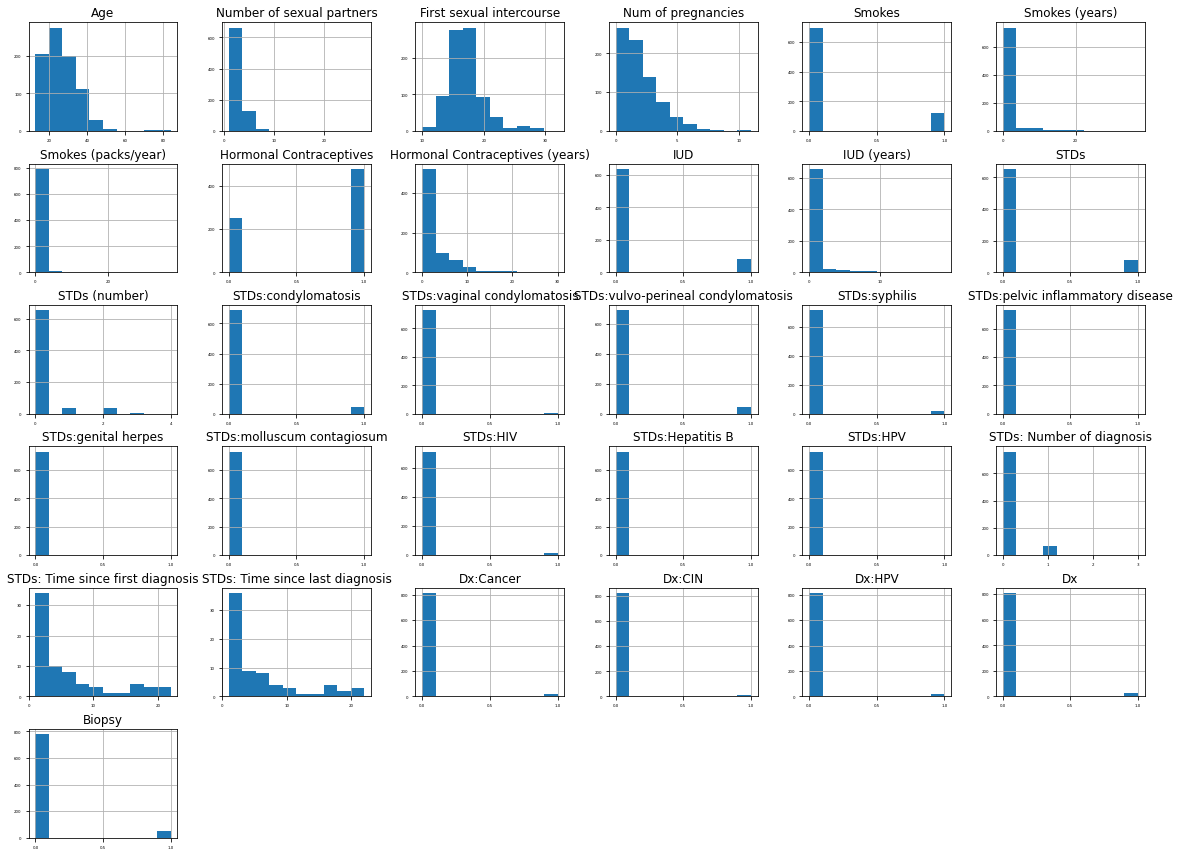

In [68]:
# histograms of the variables
fig = df.hist(figsize=[20,15], xlabelsize=4, ylabelsize=4)
# show the plot
pyplot.show()

Mostrémosla con más detalle.

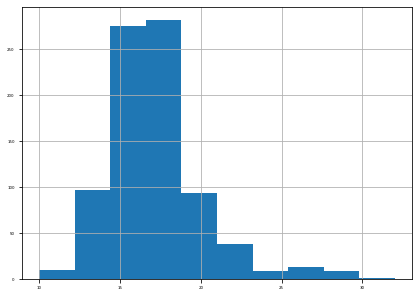

In [69]:
fig = df['First sexual intercourse'].hist(figsize=[7,5], xlabelsize=4, ylabelsize=4)
# show the plot
pyplot.show()

Eliminamos los outliers para esta variable y creamos un dataframe aparte. Si quisiéramos, podríamos obtener los resultados de estos nuevos datos filtrados, pero en nuestro caso aplicaremos otras técnicas que veremos más adelante.

In [70]:
# calculate summary statistics
data_mean, data_std = np.mean(df['First sexual intercourse']), np.std(df['First sexual intercourse'])
# define outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off

In [71]:
df_SDM = df[(df['First sexual intercourse'] >= lower) & (df['First sexual intercourse'] <= upper)]

Observamos que hemos eliminado el grupo de outliers de la derecha.

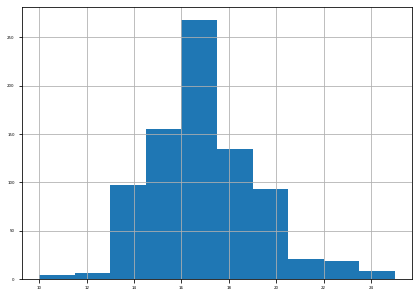

In [72]:
fig = df_SDM['First sexual intercourse'].hist(figsize=[7,5], xlabelsize=4, ylabelsize=4)
# show the plot
pyplot.show()

#### 2.4.2. Identificación de outliers mediante el Interquartile Range Method (IQR)

Si estudiamos las variables con el método IQR nos damos cuenta de varias cosas. Por un lado, muchas de las variables tienen percentiles "NaN", por lo que conviene realizar una imputación previamente. Para ello, utilizamos la imputación estadística mediante la "mediana" de cada variable.

In [73]:
# define imputer
imputer = SimpleImputer(strategy='median')  #strategy=['mean', 'median', 'most_frequent', 'constant']  constant=fixed value imputation--> 0 or 'missing_value'
# fit on the dataset
imputer.fit(X)
# transform the dataset
X_imputMedian = imputer.transform(X)

Mostremos el número de outliers identificados para cada variable por el método IQR.

In [74]:
#datos = df[['Clump_Thickness']].values
for i,datos in enumerate(X_imputMedian.T):
    print(df.columns[i])
    # calculate interquartile range
    q25, q75 = np.percentile(datos, 25), np.percentile(datos, 75)
    iqr = q75 - q25
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers = [x for x in datos if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    print()

Age
Percentiles: 25th=21.000, 75th=32.000, IQR=11.000
Identified outliers: 11

Number of sexual partners
Percentiles: 25th=2.000, 75th=3.000, IQR=1.000
Identified outliers: 68

First sexual intercourse
Percentiles: 25th=15.000, 75th=18.000, IQR=3.000
Identified outliers: 41

Num of pregnancies
Percentiles: 25th=1.000, 75th=3.000, IQR=2.000
Identified outliers: 10

Smokes
Percentiles: 25th=0.000, 75th=0.000, IQR=0.000
Identified outliers: 123

Smokes (years)
Percentiles: 25th=0.000, 75th=0.000, IQR=0.000
Identified outliers: 123

Smokes (packs/year)
Percentiles: 25th=0.000, 75th=0.000, IQR=0.000
Identified outliers: 123

Hormonal Contraceptives
Percentiles: 25th=0.000, 75th=1.000, IQR=1.000
Identified outliers: 0

Hormonal Contraceptives (years)
Percentiles: 25th=0.000, 75th=3.000, IQR=3.000
Identified outliers: 68

IUD
Percentiles: 25th=0.000, 75th=0.000, IQR=0.000
Identified outliers: 83

IUD (years)
Percentiles: 25th=0.000, 75th=0.000, IQR=0.000
Identified outliers: 83

STDs
Percenti

También hay que tener en cuenta que muchas de las variables son booleanas. Debido al desbalanceo de datos, hay variables en las que incluso nos detecta como outliers todos los miembros de la submuestra "True". Esto es algo que tener en cuenta, ya que no tiene sentido identificar outliers en variables booleanas (el filtrado por desbalanceo de datos en estas columnas ya debería haber tenido lugar en el borrado de columnas con baja varianza).

In [75]:
#datos = df[['Clump_Thickness']].values
for i,datos in enumerate(X_imputMedian.T):
    if len(np.unique(datos)) != 2:
        print(df.columns[i])
        # calculate interquartile range
        q25, q75 = np.percentile(datos, 25), np.percentile(datos, 75)
        iqr = q75 - q25
        print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
        # calculate the outlier cutoff
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        # identify outliers
        outliers = [x for x in datos if x < lower or x > upper]
        print('Identified outliers: %d' % len(outliers))
        print()

Age
Percentiles: 25th=21.000, 75th=32.000, IQR=11.000
Identified outliers: 11

Number of sexual partners
Percentiles: 25th=2.000, 75th=3.000, IQR=1.000
Identified outliers: 68

First sexual intercourse
Percentiles: 25th=15.000, 75th=18.000, IQR=3.000
Identified outliers: 41

Num of pregnancies
Percentiles: 25th=1.000, 75th=3.000, IQR=2.000
Identified outliers: 10

Smokes (years)
Percentiles: 25th=0.000, 75th=0.000, IQR=0.000
Identified outliers: 123

Smokes (packs/year)
Percentiles: 25th=0.000, 75th=0.000, IQR=0.000
Identified outliers: 123

Hormonal Contraceptives (years)
Percentiles: 25th=0.000, 75th=3.000, IQR=3.000
Identified outliers: 68

IUD (years)
Percentiles: 25th=0.000, 75th=0.000, IQR=0.000
Identified outliers: 83

STDs (number)
Percentiles: 25th=0.000, 75th=0.000, IQR=0.000
Identified outliers: 79

STDs: Number of diagnosis
Percentiles: 25th=0.000, 75th=0.000, IQR=0.000
Identified outliers: 71

STDs: Time since first diagnosis
Percentiles: 25th=4.000, 75th=4.000, IQR=0.000


#### 2.4.3. Borrado automático de outliers mediante el Local Outlier Factor (LOF)

Para poder utilizar LocalOutlierFactor en un Pipeline, creamos la siguiente clase, que nos permite combinar la técnica LOF con el modelo de predicción posterior.

In [76]:
class WithoutOutliersClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, outlier_detector, classifier):
        self.outlier_detector = outlier_detector
        self.classifier = classifier

    def fit(self, X, y):
        self.outlier_detector_ = clone(self.outlier_detector)
        mask = self.outlier_detector_.fit_predict(X, y) == 1
        self.classifier_ = clone(self.classifier).fit(X[mask], y[mask])
        return self

    def predict(self, X):
        return self.classifier_.predict(X)

Ahora, obtengamos los nuevos resultados tras eliminar los outliers.

* Dataset básico con una Iterative Imputation con estimador Bayesian Ridge y estrategia arabic, con un modelo de clasificación Random Forest (93,3510%).

In [77]:
pipeline = Pipeline(steps=[('i', IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None,imputation_order='arabic')),
                           ('rf', WithoutOutliersClassifier(LocalOutlierFactor(),RandomForestClassifier()))])
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('>%.6f (%.3f)' % (np.mean(scores), np.std(scores)))

>0.930709 (0.010)


* Dataset sin columnas con baja variedad de valores (y/o valores de baja varianza) con una KNN Imputation con k = 11, con un modelo de clasificación Logistic Regression (93,5112%).

In [78]:
pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=11)),
                           ('rf', WithoutOutliersClassifier(LocalOutlierFactor(),LogisticRegression()))])
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X_noFewValuesColumns, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('>%.6f (%.3f)' % (np.mean(scores), np.std(scores)))

>0.931904 (0.008)


* Dataset sin columnas booleanas redundantes con una Iterative Imputation con estimador Lasso Lars y estrategia roman, con un modelo de clasificación Random Forest (93,4705%).

In [79]:
pipeline = Pipeline(steps=[('i', IterativeImputer(estimator=linear_model.LassoLars(), n_nearest_features=None,imputation_order='roman')),
                           ('rf', WithoutOutliersClassifier(LocalOutlierFactor(),RandomForestClassifier()))])
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X_noBooleanRedundantColumns, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('>%.6f (%.3f)' % (np.mean(scores), np.std(scores)))

>0.930302 (0.010)


Vemos que, en general, los resultados empeoran ligeramente.

## 3. Evaluación de los mejores modelos

Por útlimo, para evaluar nuestros modelos, dividimos el dataset en dos conjuntos train y test y aplicamos las técnicas identificadas como aquellas que obtienen mejores resultados. Cabe destacar que esta división en conjunto de entrenamiento y conjunto test tendría que haberse hecho antes de evaluar nuestros modelos, ya que los datos de test pueden haber influido en nuestras decisiones a la hora de elegir unos métodos, estrategias, modelos o hiperparámetros.

Podemos observar que los resultados obtenidos son muy buenos, de un 95%.

**Nota**: Los warnings nos advierten de que no se ha aplicado ningún escalado a los datos mediante la pipeline. Para evitar que sean mostrados, se deben descomentar las dos primeras líneas de código.

In [85]:
# import warnings
# warnings.filterwarnings('ignore')

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize the shape of the training dataset
print(X_train.shape, y_train.shape)
model = Pipeline(steps=[('i', IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None,imputation_order='arabic')),
                           ('m', RandomForestClassifier(random_state=123))])
model.fit(X_train, y_train)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
ac = accuracy_score(y_test, yhat)
print('Accuracy Score: %.3f' % ac)

(557, 30) (557,)
Accuracy Score: 0.949


In [86]:
# import warnings
# warnings.filterwarnings('ignore')

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize the shape of the training dataset
print(X_train.shape, y_train.shape)
model = Pipeline(steps=[('i', KNNImputer(n_neighbors=11)),
                           ('m', LogisticRegression())])
model.fit(X_train, y_train)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
ac = accuracy_score(y_test, yhat)
print('Accuracy Score: %.3f' % ac)

(557, 30) (557,)
Accuracy Score: 0.956


In [87]:
# import warnings
# warnings.filterwarnings('ignore')

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize the shape of the training dataset
print(X_train.shape, y_train.shape)
model = Pipeline(steps=[('i', IterativeImputer(estimator=linear_model.LassoLars(), n_nearest_features=None,imputation_order='roman')),
                           ('m',RandomForestClassifier(random_state=123))])
model.fit(X_train, y_train)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
ac = accuracy_score(y_test, yhat)
print('Accuracy Score: %.3f' % ac)

(557, 30) (557,)
Accuracy Score: 0.945
